In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import cv2

In [13]:
q_prior = np.load('resources/q-prior.npy')
prior_probs = q_prior
print(q_prior.shape)
ab_gamut = np.load('resources/ab-gamut.npy')
print(ab_gamut.shape)

(313,)
(313, 2)


## Display the weights in ab gamut

In [58]:
alpha = 1
gamma = .5
# define uniform probability
uni_probs = np.zeros_like(prior_probs)
uni_probs[prior_probs != 0] = 1.
uni_probs = uni_probs / np.sum(uni_probs)

# convex combination of empirical prior and uniform distribution       
prior_mix = (1 - gamma) * prior_probs + gamma * uni_probs

# set prior factor
prior_factor = prior_mix ** -alpha
prior_factor = prior_factor / np.sum(prior_probs * prior_factor)  # re-normalize

# implied empirical prior
implied_prior = prior_probs * prior_factor
implied_prior = implied_prior / np.sum(implied_prior)  # re-normalize
#implied_prior = q_prior

\begin{equation}
\mathbf{P_{mix}} = (1-\gamma) * \mathbf{P_{prior}} + \gamma * \tfrac{1}{313} \\
\mathbf{\text{normalized_factor}} = \tfrac{\tfrac{1}{\mathbf{P_{mix}}^{\alpha}}}{\sum {\mathbf{P_{prior}}} \odot \tfrac{1}{\mathbf{P_{mix}}^{\alpha}}} \\
\mathbf{\text{umgewichtung}} = \tfrac{ \mathbf{P_{prior}} \odot \mathbf{\text{normalized_factor}} } { \sum{ \mathbf{P_{prior}} \odot \mathbf{\text{normalized_factor}}}}
\end{equation}

\begin{equation}
\text{Für alle } i \text{ in } WxH \\
class_i = \text{nearest_class}(a_i, b_i) \\
w_i = \text{umgewichtung}(class_i) \\
L = ((\hat{y^{(i)}_{a}} - y^{(i)}_{a})^2 + (\hat{y^{(i)}_{b}} - y^{(i)}_{b})^2) * w_i \\
L_{\text{MSE_GEW}} = \frac{1}{WxH}\sum_{i}^{WxH} ((\hat{y}^{(i)}_{a} - y^{(i)}_{a})^2 + (\hat{y}^{(i)}_{b} - y^{(i)}_{b})^2) * w_i
\end{equation}

In [59]:
a_max = ab_gamut[:, 0].max()
a_min = ab_gamut[:, 0].min()
b_max = ab_gamut[:, 1].max()
b_min = ab_gamut[:, 1].min()
Z = np.ones(((a_max - a_min) // 10 + 1, (b_max - b_min) // 10 + 1)) * implied_prior.min() - 0.001
for q in range(313):
    x, y = ab_gamut[q]
    x = (x // 10) - a_min // 10
    y = (y // 10) - b_min // 10
    Z[x, y] = implied_prior[q]

In [60]:
# create a color map
n=100000
x = 1
colors = plt.cm.jet(np.linspace(0, x, n))
white = np.zeros((1, 4))
colors = np.vstack(( white, colors))
tmap = matplotlib.colors.LinearSegmentedColormap.from_list('map_white', colors)

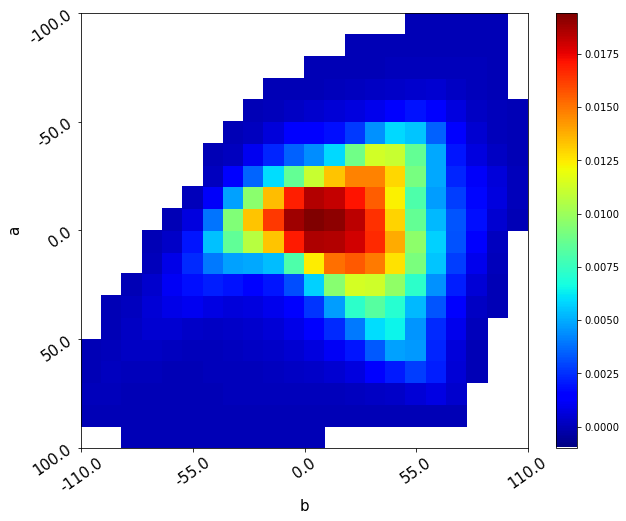

In [61]:
plt.figure(figsize=(10, 8))

cb = plt.pcolor(Z[::-1, :], vmin=Z.min(), vmax=implied_prior.max(), cmap=tmap)
plt.colorbar(cb)
plt.xticks(np.linspace(0, Z.shape[1], 5), list(map(str, np.linspace(b_min, b_max + 10, 5).tolist())), rotation=35., fontsize=15);
plt.yticks(np.linspace(0, Z.shape[0], 5), list(map(str, np.linspace(a_max, a_min - 10, 5).tolist())), rotation=35., fontsize=15);
plt.xlabel('b', fontsize=15)
plt.ylabel('a', fontsize=15);
plt.savefig('prior_distribution.png')

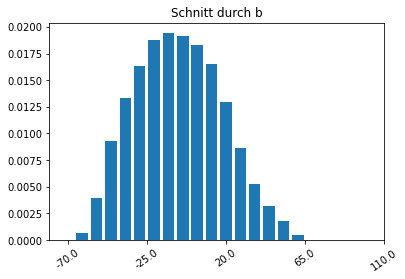

In [62]:
plt.bar(np.arange(18), Z[9, 4:])
plt.xticks(np.linspace(0, Z.shape[1], 5), list(map(str, np.linspace(b_min + 40, b_max + 10, 5).tolist())),
           rotation=35.);
plt.title('Schnitt durch b');

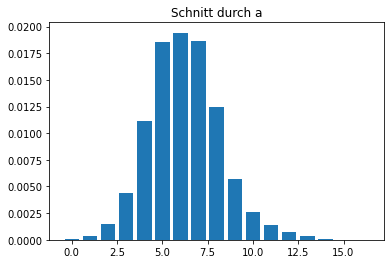

In [63]:
plt.bar(np.arange(17), Z[3:, 11])
plt.title('Schnitt durch a');

# Weigh an example image

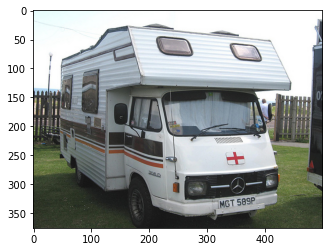

In [64]:
img = cv2.imread('resources/ILSVRC2012_val_00000014.JPEG')
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
h, w = img.shape[:2]
ab = torch.from_numpy(img_lab[:, :, 1:]).permute(2, 0, 1).float()
ab = torch.stack([ab, ab])
ab = ab.reshape(2, 2, -1)
implied_prior_t = torch.from_numpy(implied_prior)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [65]:
ref = torch.from_numpy(ab_gamut).float() + 128
points = torch.transpose(ab, 2, 1)
cdist = torch.cdist(ref, points)
nns = cdist.argmin(1)
weights_implied = implied_prior[nns].reshape(2, h, w)
weights_prior = q_prior[nns].reshape(2, h, w)

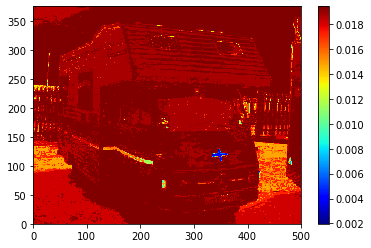

In [66]:
cb = plt.pcolor(weights_implied[0, ::-1],cmap='jet')
plt.colorbar(cb)

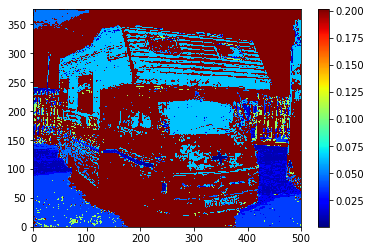

In [67]:
cb = plt.pcolor(weights_prior[0, ::-1],cmap='jet')
plt.colorbar(cb)

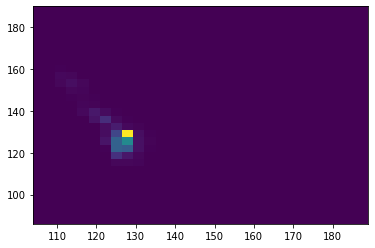

In [125]:
plt.hist2d(ab[0, 0, :].numpy(), ab[0, 1, :].numpy(), bins=30);